# Цели и задачи проекта

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки. Нам предстоит выбрать наиболее приоритетную гипотезу и проверить её перспективность с помощью A/B-теста.
В ходе проекта мы проделаем следующее:
- приоритизируем гипотезы
- запустим A/B-тест и 
- проанализируем результаты:
 - Оценка стабильности кумулятивных метрик
 - Анализ выбросов и всплесков
 - Анализ «сырых» и «очищенных» данных
 


## Часть 1. Приоритизация гипотез.
У нас есть 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Основываясь на этих параметрах, определим, с какой гипотизы стоит начинать тестирование. 

Для этого у нас есть Файл /datasets/hypothesis.csv с оценеными вышеупомянутыми параметрами.
Hypothesis — краткое описание гипотезы;
Reach — охват пользователей по 10-балльной шкале;
Impact — влияние на пользователей по 10-балльной шкале;
Confidence — уверенность в гипотезе по 10-балльной шкале;
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

### Для начала ознакомимся с данными

In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
data = pd.read_csv('/datasets/hypothesis.csv', sep=',')

print(data)

                                          Hypothesis  Reach  Impact  \
0  Добавить два новых канала привлечения трафика,...      3      10   
1  Запустить собственную службу доставки, что сок...      2       5   
2  Добавить блоки рекомендаций товаров на сайт ин...      8       3   
3  Изменить структура категорий, что увеличит кон...      8       3   
4  Изменить цвет фона главной страницы, чтобы уве...      3       1   
5  Добавить страницу отзывов клиентов о магазине,...      3       2   
6  Показать на главной странице баннеры с актуаль...      5       3   
7  Добавить форму подписки на все основные страни...     10       7   
8  Запустить акцию, дающую скидку на товар в день...      1       9   

   Confidence  Efforts  
0           8        6  
1           4       10  
2           7        3  
3           3        8  
4           1        1  
5           2        3  
6           8        3  
7           8        5  
8           9        5  


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Данные выглядят равномерными, перейдем сразу к приоритизации гипотез

###  Применим фреймворк ICE для приоритизации гипотез. 

In [4]:
data['ICE'] = ((data['Impact'] * data['Confidence'])/data['Efforts']).round(2)

display(data[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


Исходя из оценки выше, наиболее перспективные гипотезы - номер 8, 0 и 7. Посмотрим, как позиции изменятся при учтении охвата пользователей.

### Применим фреймворк RICE для приоритизации гипотез. 


In [5]:

data['RICE'] = ((data['Reach'] * data['Impact'] * data['Confidence'])/data['Efforts']).round(2)

display(data[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Добавив еще один параметр - охват пользователей, мы видим изменение в порядке гипотез. Гипотезы 0 и 7 все еще в топ-3, однако на других позициях. При этом, гипотеза 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) значительно оторвалась от остальных за счет охвата всех посетителей онлайн магазина, а гипотеза 8 (Запустить акцию, дающую скидку на товар в день рождения) касается только тех пользователей, которые родились в определенный период.

## Часть 2. Анализ результатов A/B-теста


Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv. Теперь нам надо проанализировать результаты и выяснить, стоит ли продолжать тест и считать ли его успешным. 

Для этого мы оценим результаты по следующим показателям: 
- общая выручка
- средний чек
- общее количество заказов
- количество заказов на посетителя сайта


### Знакомство и предобработка данных
Начнем с того, что ознакомимся с данными и их структурой.

In [6]:
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])


In [7]:
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
print(visitors.duplicated().sum())
print(orders.duplicated().sum())

0
0


In [9]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
print(visitors.isna().sum())
print(orders.isna().sum())

date        0
group       0
visitors    0
dtype: int64
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


Данные равномерные, без пропусков и дубликатов. Названия столбцов и типы данных соответствуют самим данным.

In [12]:
print(orders['date'].max())
print(orders['date'].min())

2019-08-31 00:00:00
2019-08-01 00:00:00


In [13]:
print('Посетителей в группе А:', orders[orders['group']=='A']['visitorId'].count())
print('Посетителей в группе В:', orders[orders['group']=='B']['visitorId'].count())

Посетителей в группе А: 557
Посетителей в группе В: 640



Итого, в результате А/В теста, у нас есть две группы -  А и В. Тест проходил в течение 30 дней с 1 по 31 августа 2019 года. В группе В значительно больше посетителей, чем в группе А, учтем это при сравнении общей выручки. На показатели средней выручки и количество заказов на пользователя сильного влияние это не окажет.

In [14]:
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()
double_users = orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId'].unique()


In [15]:
orders = orders.query('visitorId not in @double_users')


### Оценка стабильности кумулятивных метрик

Для понимания достаточно ли у нас данных для анализа результатов теста, на надо оценить стабильность кумулятивных метрик. Сначала соберем данные в таблицу cumulativeData.

In [16]:

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Построим график кумулятивной выручки по группам.

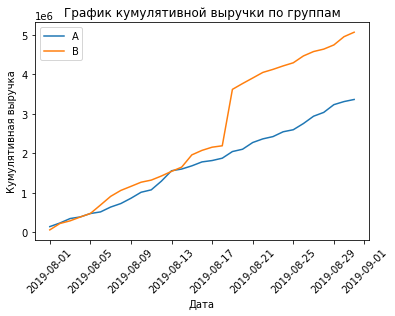

In [17]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Кумулятивная выручка')
plt.xlabel('Дата')
plt.xticks(rotation='45')
plt.legend(); 

Из графика видим, что выручка группы В значительно превышает выручку группы А, однако, мы знаем, что в группе В больше посетителей, чем в группе А, поэтому средний чек будет более показательным.
На графике есть резкий всплеск, что скорее всего указывает на выбросы в данных.

Посмотрим на график кумулятивного среднего чека по группам.

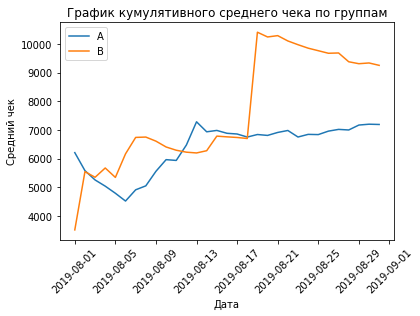

In [18]:

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation='45');

Опять же группа В сильно опережает и всплеск так же остается, после чего средний чек группы В начинает стабилизироваться. В группе В скорее всего есть выбросы с большими суммами заказов.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

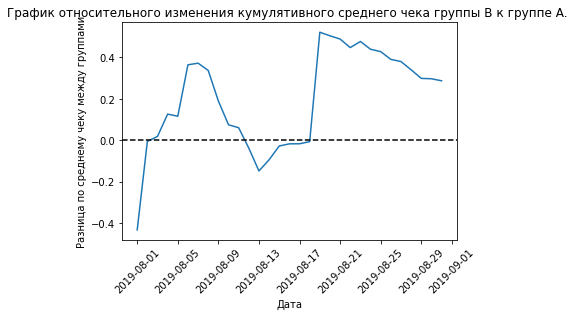

In [19]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
x = mergedCumulativeRevenue['date']
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Разница по среднему чеку между группами')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A. ')
plt.xticks(rotation='45');


Не смотря на всплески и выбросы, мы видим, что средний чек группы В постоянно лучше группы А

Построим график кумулятивного среднего количества заказов на посетителя по группам. 

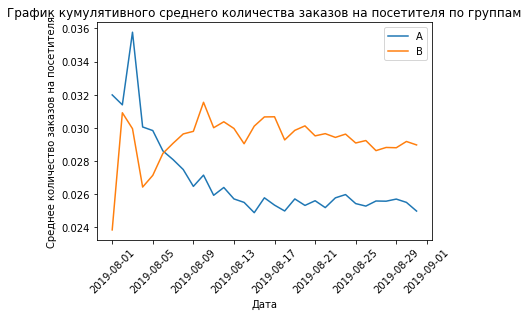

In [20]:
cumulativeOrdPerUserA = cumulativeData[cumulativeData['group']=='A'][['date','visitors', 'orders']]
cumulativeOrdPerUserB = cumulativeData[cumulativeData['group']=='B'][['date','visitors', 'orders']]

plt.plot(cumulativeOrdPerUserA['date'], cumulativeOrdPerUserA['orders']/cumulativeOrdPerUserA['visitors'], label='A')
plt.plot(cumulativeOrdPerUserB['date'], cumulativeOrdPerUserB['orders']/cumulativeOrdPerUserB['visitors'], label='B')
plt.legend()
plt.ylabel('Среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xticks(rotation='45');

Опять же группа В показывает лучшие результаты и по среднему количеству заказов на посетителя. Показательно, что оба графика стабилизировались, а значит, у нас достаточно данных для оценки.

Теперь построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

In [21]:
# собираем данные в одном датафрейме
mergedCumulativeOrdPerUser = cumulativeOrdPerUserA.merge(cumulativeOrdPerUserB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


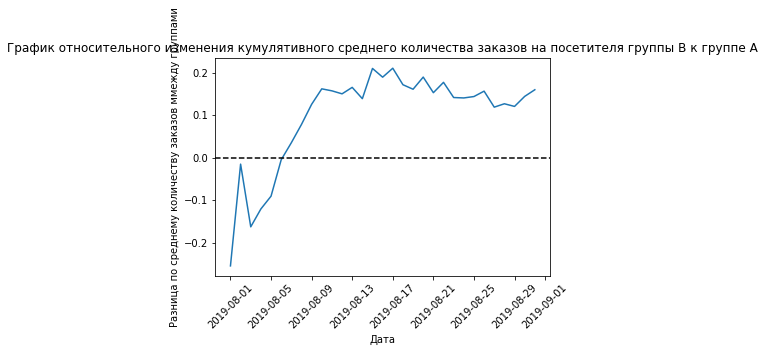

In [22]:

# cтроим отношение средних чеков
plt.plot(mergedCumulativeOrdPerUser['date'], (mergedCumulativeOrdPerUser['ordersB']/mergedCumulativeOrdPerUser['visitorsB'])/
         (mergedCumulativeOrdPerUser['ordersA']/mergedCumulativeOrdPerUser['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Разница по среднему количеству заказов ммежду группами')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(rotation='45');

И снова ожидаемый результат - группа В показывает большее количество заказов на посетителя. Мы могли бы уже сделать вывод, что тест пора признать успешным, однако, мы помним, что в данных есть выбросы и стоит оценить их влияние на результат.

### Анализ выбросов и всплесков

Сначала посмотрим, как распределены заказы по пользователям, лучше всего это покажет точечный график. 

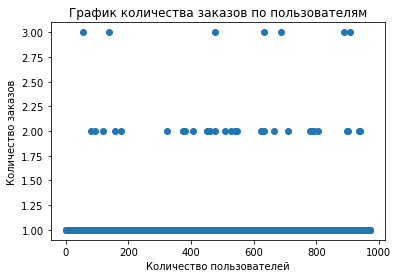

In [23]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
plt.title('График количества заказов по пользователям');

    Большинство клиентов сделали по одному-двум заказам. Четыре и более заказов - большая редкость. 
    Посчитаем 95-й и 99-й перцентили количества заказов на пользователей для того, чтобы в последствии выбрать границу для определения аномальных пользователей.

In [24]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]) )


[1. 1. 2.]


Как мы и предполагали, 95% пользователей сделали два и меньше заказов и 99% не более 4. Теперь оценим, выбросы в стоимостях заказов.

Построим точечный график стоимостей заказов. 


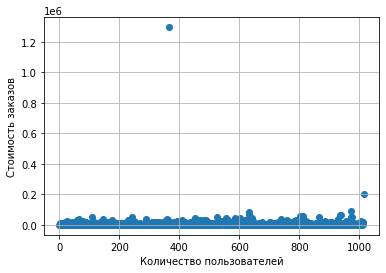

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.grid(True)
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.scatter(x_values, orders['revenue']);

В данных очень большой всплеск, посмотрим, как выглдит распределение без заказов дороже 120000 

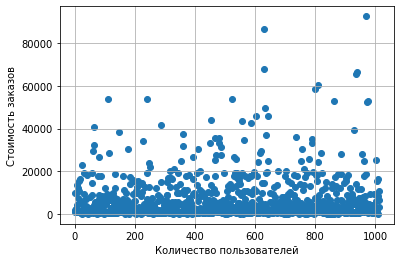

In [26]:
orders_filt = orders[orders['revenue']<120000]
x_values = pd.Series(range(0, len(orders_filt['revenue'])))
plt.grid(True)
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.scatter(x_values, orders_filt['revenue']);

Исходя из графика можно предположить, что большинство заказов не превышают 20000.
Посмотрим, что покажут 95-й и 99-й перцентили стоимости заказов. 
Тогда мы сможем выбрать границу для определения аномальных заказов.


In [27]:
print(np.percentile(orders['revenue'], [90, 95, 99]) )


[17990. 26785. 53904.]


Неожиданно, 95% покупателей сделали заказы на сумму до 28000, при том, что 95% на сумму до 31382 и совсем большую разницу представляют следующие 3% покупателей, повышающие этот параметр до 58233.2. 

Мы можем сделать вывод, что 4 и более заказов можно считать аномальными, как и сумма заказа выше 35000. 

###  Анализ «сырых» и «очищенных» данных

Посчитаем статистическую значимость различий в среднем числе заказов на посетителя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: 
различия в среднем между группами есть.

Учитывая наличие выбросов в данных, мы не можем использовать параметрические тесты, в связи с чем, мы будем использовать критерий Уилкоксона-Манна-Уитни, позволяющий анализировать данные с выбросами.

In [28]:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId','revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("относительная разница в среднем количестве заказов на посетителя {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.011
относительная разница в среднем количестве заказов на посетителя 0.160


Вывод: По «сырым» данным различия в среднем числе заказов групп A и B есть. 
    Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, можно отвергнуть. Относительный выигрыш группы B равен 16.0%.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 
    Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
    А ещё найдём относительные различия в среднем чеке между группами:


In [30]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('относительная разница в среднем чеке между группами {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


p-value = 0.829
относительная разница в среднем чеке между группами 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

Наверняка, в этом виноваты выбросы и их стоит отбросить и посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Напомним, что найденные 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 35 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 35 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [32]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsersA['orders'], 99)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsersB['orders'], 99)]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 97.1)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Всего выбивающихся значений: ', abnormalUsers.shape[0])
print('Отношение выбивающихся значений к общим: = {0:.2f}%'.format((abnormalUsers.shape[0]/orders['visitorId'].nunique())*100))

Всего выбивающихся значений:  37
Отношение выбивающихся значений к общим: = 3.80%


37 записей - меньше 4% от всех данных, можем с ними попрощаться.
Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [33]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительная разница в среднем количестве заказов на посетителя {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.007
относительная разница в среднем количестве заказов на посетителя 0.194


Результаты по среднему количеству заказов изменились, не не сильно. Произошло ли что-нибудь с результатами по среднему чеку?

In [34]:
print(
    'p-value ={0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "относительная разница в среднем чеке между группами {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value =0.869
относительная разница в среднем чеке между группами 0.003


P-value увеличился, но и разница между сегментами сократилась с 26% до 3%.
Хотя общие выводы по результатам теста не изменились, такой пример хорошо показывает, как сильно аномалии могут влиять на результаты A/B-теста!

# Выводы по проекту
Имеющиеся факты:
Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий - группа В однозначно опережает группу А;
Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
График различия среднего количества заказов, как и выручки и среднего чека между группами сообщает, что результаты группы B лучше группы A

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным.